![image](https://www.ewatercycle.org/assets/logo.png)

# Case study 1: replace subbasin in PCRGlobWB2.0 with a MARRMoT model
This notebooks demonstrates how to use eWaterCycle to combine the output of two very different models in a single experiment. We run PCRGlobWB2.0 for the Rhine basin, but we replace the Moselle sub-basin with a MARRMoT model.

PCRGlobWB2.0 (Edwin 20XX) is a distributed model written in python and MARRMoT (Knoben 20XX) is a suite of conceptual models written in Matlab. To make the difference as large as possible, we choose the simplest model available within MARRMoT: the m01, a single leaky bucket.

## Import statements
We'll be using the following modules

In [2]:
import os
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from cartopy import crs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cftime import num2date
from ewatercycle import CFG
from ewatercycle.analysis import hydrograph
from ewatercycle.models import MarrmotM01, PCRGlobWB
from ewatercycle.observation.grdc import get_grdc_data
from ewatercycle.util import lat_lon_to_closest_variable_indices

In [3]:
CFG.load_from_file('ewatercycle.yaml')

## List of files created for this experiment

### for PCRGlobWB2.0

- `rhine_05min_era5.ini` This file is identical to the file with the same name used in the big comparison study. The only difference is that the time period (variables startTime and endTime) have been set to 2002-01-01 and 2002-12-31 respectivly. 
- `rhine_05min_era5_without_moselle.ini` This file is identical to rhine_05in_era5.ini with the only exception that the landmask variable points to no_moselle_landmask_05min_rhine.map in the input directory
- `no_moselle_landmask_05min_rhine.map` This file is based on rhine_05min.map. Using a shape file with the shape of the Moselle catchment (see MARRMoT below) all pixels that are part of the moselle catchment have been removed (set to zero) in this landmask.

### for MARRMoT

- `marrmot_ERA5_Moselle_2001_2016.mat` This file contains the forcing that MARRMoT needs to run. It was created by running the ESMVAlTool recipe (TODO Jerom to provide details)

## Settings and parameters to run this experiment
The settings below are seperated in settings that 'belong' to the experiment, those that belong to PCRGlobWB or those that belong with MARRMoT

In [4]:
#Settings for this experiment

# The project home directory where data lives and output should be written
PROJECT_HOME = Path(os.path.abspath("/mnt/home/user36/temp/Case1"))
DATA_HOME = Path(os.path.abspath("/mnt/data/examples/technical_paper"))

# Settings for GRDC station for final comparison of streamflow
dstart = '2002-01-01'
dend = '2002-12-31'
station_id = '6335020' # GRDC station ID
basin_name = 'Rhine'

# Location of the mouth of the Moselle. The closest PCRGlobWB pixel to this location will
# be used to 'dump' the output of MARRMoT into the 'channel_storage' of PCRGlobWB. Location
# from Google maps.
lat_moselle_mouth = [50.366852]
lon_moselle_mouth = [7.609666] 

In [5]:
#Settings for PCRGlobWB2.0
pcrglob_input_dir=str(DATA_HOME / 'pcr-globwb' / 'input')

pcrglob_ref_setting_file = str(PROJECT_HOME  / 'settingFiles' / 'rhine_05min_era5.ini')
pcrglob_exp_setting_file = str(PROJECT_HOME / 'settingFiles' / 'rhine_05min_era5_without_moselle.ini')

In [6]:
#Settings for MARRMoT

# forcing dataset and directory
marrmot_forcing_dir = DATA_HOME / "marrmot" / "marrmotForcing" / "validation"
marrmot_forcing_file = "marrmot_ERA5_Moselle_2001_2016.mat"

# shape file that was used to delineate the catchment, is needed here to calculate area
shapefile = DATA_HOME / "marrmot"/ "marrmotForcing" / "Moselle.shp"

#TODO: start en end time is repeated too often
# test period for both validation and calibration (Year, Month, Date)
period = {
    "spinup": datetime(2001, 1, 1,0,0,0),
    "start": datetime(2002, 1, 1,0,0,0),
    "end": datetime(2002, 12, 31,0,0,0),
}

# variable of interest to get out of the model
marrmot_output_variable = "flux_out_Q"

# flux_out_Q unit conversion factor from mm/day to m3/s
conversion_mmday2m3s = 1 / (1000 * 86400)

# parameters, in this case max soil moisture storage (in mm), ranging between 100 en 2000
# https://github.com/wknoben/MARRMoT/blob/dev-docker-BMI/MARRMoT/Models/Parameter%20range%20files
maximum_soil_moisture_storage = 1500.0
initial_soil_moisture_storage = 0.9 * maximum_soil_moisture_storage

## Derived directories and constants


In [7]:
# project directories for model input i.e. shape files and forcing
shape = shapereader.Reader(shapefile)
attr = next(shape.records())
moselle_area = attr.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", moselle_area)

The catchment area is: 28101200000.0


## Setting up the model objects
For MARRMoT we first need to generate a config file. After that is done, the three BMI model objects are created

In [12]:
marrmot_model = MarrmotM01()

# Create config file and write to work directory (cfg_dir)
# Start up a container for MARRMoT
marrmot_cfg_file, marrmot_cfg_dir = marrmot_model.setup(
    forcing=marrmot_forcing_dir / marrmot_forcing_file,
    # No need to specifiy start and end date, using dates from forcing_output
    maximum_soil_moisture_storage=maximum_soil_moisture_storage,
    initial_soil_moisture_storage=initial_soil_moisture_storage,
)
marrmot_cfg_file, marrmot_cfg_dir

(PosixPath('/mnt/home/user36/temp/Case1/marrmot_20210423_143734/marrmot-m01_config.mat'),
 PosixPath('/mnt/home/user36/temp/Case1/marrmot_20210423_143734'))

In [13]:
# Initialize using the created config file
marrmot_model.initialize(str(marrmot_cfg_file))

In [14]:
# MARRMot needs to spin-up, so we run it for a while, see the period for timing
marrmot_time_units = marrmot_model.time_units
while num2date(marrmot_model.time, marrmot_time_units) < period["start"]:
    marrmot_model.update()

In [40]:
pcrglob_ref_model = PCRGlobWB()
# Start up a container for PCRGlob for the reference run 
pcrglob_ref_cfg_file, pcrglob_Ref_cfg_dir = pcrglob_ref_model.setup(
    input_dir=pcrglob_input_dir,
    cfg_file=pcrglob_ref_setting_file)
pcrglob_ref_cfg_file, pcrglob_Ref_cfg_dir

Created working directory: /mnt/home/user36/temp/Case1/pcrglobwb_20210426_145525
Created config file /mnt/home/user36/temp/Case1/pcrglobwb_20210426_145525/pcrglobwb_ewatercycle.ini with inputDir /mnt/data/examples/technical_paper/pcr-globwb/input and outputDir /mnt/home/user36/temp/Case1/pcrglobwb_20210426_145525.
Started model container with working directory /mnt/home/user36/temp/Case1/pcrglobwb_20210426_145525 and access to the following input directories:
/mnt/data/examples/technical_paper/pcr-globwb/input.


(PosixPath('/mnt/home/user36/temp/Case1/pcrglobwb_20210426_145525/pcrglobwb_ewatercycle.ini'),
 PosixPath('/mnt/home/user36/temp/Case1/pcrglobwb_20210426_145525'))

In [41]:
# Initialize using the setting file
pcrglob_ref_model.initialize(str(pcrglob_ref_cfg_file))

In [42]:
# Print available output variable names of PCRGlob model
pd.Series(sorted(pcrglob_ref_model.output_var_names))

0                   accumulated_land_surface_baseflow
1                               bare_soil_evaporation
2                                            baseflow
3                                     channel_storage
4     consumptive_water_use_for_non_irrigation_demand
                           ...                       
92                                 upper_soil_storage
93                           upper_soil_transpiration
94                      water_body_actual_evaporation
95                    water_body_evaporation_fraction
96                   water_body_potential_evaporation
Length: 97, dtype: object

In [8]:
# Start up a container for PCRGlob for the experiment run 
pcrglob_exp_model = PCRGlobWB()
# Start up a container for PCRGlob for the reference run 
pcrglob_exp_cfg_file, pcrglob_exp_cfg_dir = pcrglob_exp_model.setup(
    input_dir=pcrglob_input_dir,
    cfg_file=pcrglob_exp_setting_file)
pcrglob_exp_cfg_file, pcrglob_exp_cfg_dir

Created working directory: /mnt/home/user36/temp/Case1/pcrglobwb_20210423_143431
Created config file /mnt/home/user36/temp/Case1/pcrglobwb_20210423_143431/pcrglobwb_ewatercycle.ini with inputDir /mnt/data/examples/technical_paper/pcr-globwb/input and outputDir /mnt/home/user36/temp/Case1/pcrglobwb_20210423_143431.
Started model container with working directory /mnt/home/user36/temp/Case1/pcrglobwb_20210423_143431 and access to the following input directories:
/mnt/data/examples/technical_paper/pcr-globwb/input.


(PosixPath('/mnt/home/user36/temp/Case1/pcrglobwb_20210423_143431/pcrglobwb_ewatercycle.ini'),
 PosixPath('/mnt/home/user36/temp/Case1/pcrglobwb_20210423_143431'))

In [9]:
# Initialize using the setting file
pcrglob_exp_model.initialize(str(pcrglob_exp_cfg_file))

In [10]:
# Now that we have a BMI model for the experiment, we can query which model pixel is closest
# to the mouth of the Moselle, expressed in 'indices', ie. model pixel number.
moselle_mouth_indices = lat_lon_to_closest_variable_indices(
    pcrglob_exp_model,
    'channel_storage',
    lat_moselle_mouth,
    lon_moselle_mouth
)
moselle_mouth_indices

array(6004)

## Running the experiment
With all pieces in place, we can now start to run the actual experiment. Each timestep first the reference model (PCRGlobWB 2.0 with the Moselle) is run and it's output stored. Subsequently, MARRMoT is run, it's output is stored and it is added to the experiment model (PCRGlobWB 2.0 without the Moselle). Than, finally, the experiment model is run for one timestep, it's output stored and we go on to the next timestep.

In [19]:
# Create variables needed during the experiment run
pcrglob_ref_output = []
pcrglob_exp_output = []
marrmot_output = []

pcrglob_time_units = pcrglob_exp_model.time_units

In [20]:
print(f'Running experiment', flush=True)

#the experiment model is used as central 'time keeper'
while pcrglob_exp_model.time < pcrglob_exp_model.end_time:
    
    #get the current time to print
    time = num2date(pcrglob_exp_model.time, pcrglob_time_units)
    print(f'Current time: {time}', end="\r")

    #run the reference model for one timestep, store the output
    pcrglob_ref_model.update()
    pcrglob_ref_output.append(pcrglob_ref_model.get_value_as_xarray("discharge"))
    
    #run MARRMoT and store the output, note that MARRMoT output is in mm!
    marrmot_model.update()
    marrmot_output.append(marrmot_model.get_value(marrmot_output_variable)[0])
    
    #add the output of MARRMoT to PCRGlob Experiment model. Note that channel storage
    # is in m3, while MARRMoT output is in mm, so we need to convert
    water_to_add_to_PCRGlob = marrmot_output[-1] * moselle_area / 1000 #now in m3
    value_to_set_in_PCRGlob = water_to_add_to_PCRGlob + pcrglob_exp_model.bmi.get_value_at_indices('channel_storage', moselle_mouth_indices)
    pcrglob_exp_model.bmi.set_value_at_indices('channel_storage', moselle_mouth_indices, value_to_set_in_PCRGlob)
    
    #Run the experiment PCRGlobWB model one timestep, store the output
    pcrglob_exp_model.update()
    pcrglob_exp_output.append(pcrglob_exp_model.get_value_as_xarray("discharge"))
    
print('')

Running experiment
Current time: 2002-12-30 00:00:00


### clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [ ]:
pcrglob_ref_model.finalize()
pcrglob_exp_model.finalize()
marrmot_model.finalize()

del pcrglob_exp_model.bmi
del pcrglob_ref_model.bmi
del marrmot_model.bmi

Combine values of each time step into single dataset

In [ ]:
data_exp = xr.concat(pcrglob_exp_output, dim='time')
data_ref = xr.concat(pcrglob_ref_output, dim='time')

In [ ]:
# Store results on disk
# data_exp.to_netcdf(pcrglob_exp_cfg_dir / 'data_exp.nc')
# data_ref.to_netcdf(pcrglob_Ref_cfg_dir / 'data_ref.nc')

In [8]:
# Retrieve results from disk when models are run in seperate session
# data_exp = xr.open_dataset(Path('/mnt/home/user36/temp/Case1/pcrglobwb_20210426_100036') / 'data_exp.nc')
# data_ref = xr.open_dataset(Path('/mnt/home/user36/temp/Case1/pcrglobwb_20210426_095636') / 'data_ref.nc')

### Import GRDC observations

Read the GRDC data for the period of the experiment, for the station given above. 
If you are not on jupyter.ewatercycle.org or Cartesius, download the GRDC https://www.bafg.de/GRDC/EN/02_srvcs/21_tmsrs/riverdischarge_node.html and set the `grdc_location` field in `./ewatercycle.yaml` to your download location.

In [9]:
observations = get_grdc_data(
    station_id, 
    start_date=dstart, 
    end_date=dend,
    data_home='CFG["grdc_location"]'
)
grdc_obs = observations.to_dataframe().rename(columns = {'streamflow': 'Observations from GRDC'})
grdc_lon = observations.attrs['grdc_longitude_in_arc_degree']
grdc_lat = observations.attrs['grdc_latitude_in_arc_degree']

## Plot the results

Find pixel in model grid of GRDC station location using highest overall discharge around the station.

In [14]:
pad=.2

# Write data for model output at GRDC location to pandas series,
# Use padding and max to correct for GRDC station location error

#TODO get model output pixel closest to some lat-lon needs to be a util.

data_exp_at_grdc_location = data_exp.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename({'discharge': 'PCRGlobWB Moselle replaced by MARRMoT-m01'}
                        ).to_dataframe()

data_ref_at_grdc_location = data_ref.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename({'discharge': 'PCRGlobWB normal'}
                        ).to_dataframe()

Map of exp at the final time step

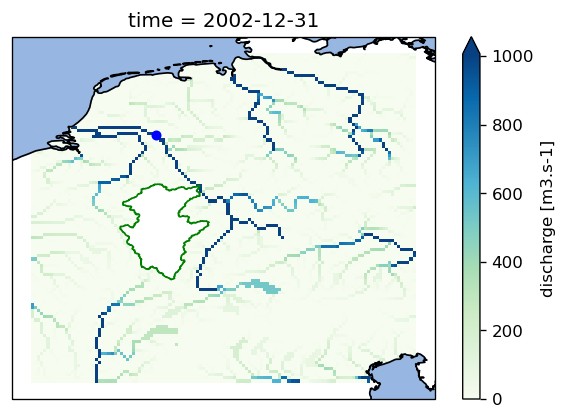

In [23]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Add the mosell catchment to the map
ax.add_feature(cfeature.ShapelyFeature(
    shape.geometries(), 
    crs.PlateCarree(), 
    edgecolor="green",
    facecolor='none',
))

# Plotting the model field is a one-liner
data_exp.discharge.isel(time=-1).plot(ax=ax, cmap='GnBu', robust=True)

# Also plot the station location
ax.scatter(grdc_lon, grdc_lat, s=25, c='b')
# TODO plot the grid cell of model for which hydrograph is made
# ax.scatter(model_longitude, model_latitude, s=25, c='r')

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.coastlines(zorder=3)
fig.savefig(f'pcrglobwb_RolfTestRhine_discharge_map', bbox_inches='tight', dpi=300)

In [22]:
# Combine timeseries of ERA-Interim, ERA5 and GRDC observations in a pandas dataframe
df = data_exp_at_grdc_location.join(data_ref_at_grdc_location).join(grdc_obs)
df

,PCRGlobWB Moselle replaced by MARRMoT-m01,PCRGlobWB normal,Observations from GRDC
time,,,
2002-01-01,4551.247559,4551.247559,4120.0
2002-01-02,4682.305664,4709.530273,5010.0
2002-01-03,4199.963867,4644.274902,5220.0
2002-01-04,3453.768799,3974.360352,4460.0
2002-01-05,2125.878906,2586.708740,3570.0
...,...,...,...
2002-12-27,8887.804688,5869.155762,4560.0
2002-12-28,5070.899902,5683.294922,4420.0
2002-12-29,4764.223145,4863.405273,4350.0


(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

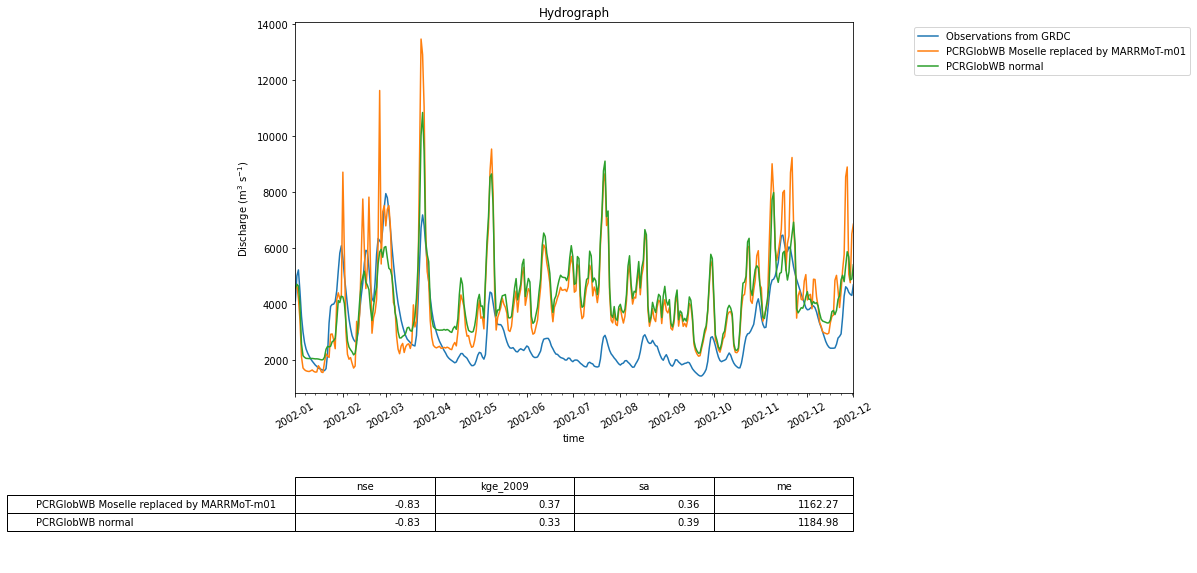

In [25]:
hydrograph(
    discharge=df,
    reference='Observations from GRDC',
    filename=f'pcrglobwb_{basin_name}_hydrograph'
)